# Module 13 背景提取 & hough 霍夫變換
> 背景減除 (Background Subtraction) 是許多基於計算機視覺的任務中的主要預處理步驟。如果我們有完整的``靜止的背景幀``,那麼我們可以通過``幀差法``來計算畫素差從而獲取到前景物件。但是在大多數情況下, 我們可能沒有這樣的影像, 所以我們需要從我們擁有的任何影像中``提取背景``。當運動物體有陰影時,由於陰影也在移動,情況會變的變得更加複雜。為此引入了背景減除演算法,通過這一方法我們能夠從視訊中``分離出運動的物體前景``, 從而達到目標檢測的目的。 OpenCV已經實現了幾種非常容易使用的演算法。

> ``大多數場景中相機的位置也是相對固定的, 尤其是在視頻安全程式中。在學習背景分割之前，首先需要瞭解背景模型``

> ### 幀差法 :
> 用前面一幀作為背景圖像，與當前幀進行相減，如果其相減後的絕對值大於閾值，則圖元點變為255， 否則變為0，通過這種方法來找出視頻中運動的物體<br>

>不過這種方法對光照與噪聲影響非常敏感，好的辦法是通過對``前面一系列幀提取背景模型進行相減``，OpenCV中實現的背景模型提取算法有兩種，一種是基於高斯混合模型GMM實現的背景提取，另外一種是基於最近鄰KNN實現的。

><img src=".\image\mog_diff.jpg"  style='height:300px; width:600px'>

## 13-1 MOG 背景提取
> ### 高斯混合模型分離演算法, 全稱 Mixture of Gaussians
> 它使用 K（K=3 或 5）個高斯分佈混合對背景圖元進行建模。混合的權重表示這些顏色停留在場景中的時間比例，``背景顏色是那些保持更長時間和更靜態的顏色``。

> 在編寫代碼時，我們需要使用函數 ：``cv2.createBackgroundSubtractorMOG()`` 創建一個背景物件。這個函數有些可選參數，比如要進行建模場景的時間長度，高斯混合成分的數量，閾值等。將他們``全部設置為預設值``。然後在整個視頻中我們是需要使用 backgroundsubtractor.apply() 就可以得到前景的遮罩圖。

> default : history=200, nmixtures=5, backgroundRatio=0.7

In [20]:
# import numpy as np
import cv2

# cap = cv2.VideoCapture('./video/vtest.avi')
cap = cv2.VideoCapture('./video/overpass.mp4')
# cap = cv2.VideoCapture(0)

# default : history=200, nmixtures=5, backgroundRatio=0.7
fgbg = cv2.bgsegm.createBackgroundSubtractorMOG(history=200, nmixtures=6, backgroundRatio=0.7)   # try history = 1
fgbg1 = cv2.bgsegm.createBackgroundSubtractorMOG(history=1, nmixtures=5, backgroundRatio=0.7)   # try history = 1
# fgbg = cv2.createBackgroundSubtractorMOG2()

while True :
    ret, frame = cap.read()

    frame = cv2.resize(frame, (600, 400), interpolation = cv2.INTER_NEAREST)
#     frame = cv2.resize(frame, (800, 450), interpolation = cv2.INTER_LINEAR)

    fgmask = fgbg.apply(frame)            # fgbg
    fgmask1 = fgbg1.apply(frame)            # fgbg1
    cv2.imshow('original', frame)
    cv2.imshow('MOG hist = 200', fgmask)
    cv2.imshow('MOG hist = 1', fgmask1)
    k = cv2.waitKey(50) & 0xff
    if k == 27:
        break

cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

### MOG2 : 高斯混合模型分離演算法,是 MOG 的改進演算法 Geometric Multigid
> 這個演算法的一個特點是它為每一個圖元選擇一個``合適數目的高斯分佈``。（上一個方法中我們使用是 ``K 高斯分佈``）。它能更好地適應光照不同等各種場景。 和前面一樣我們需要創建一個背景物件。但在這裡我們可以選擇是否檢測陰影。如果 detectShadows = True（預設值），它就會檢測並將影子標記出來，但是這樣做會降低處理速度。影子會被標記為灰色。

> 主要通過視頻中的背景進行建模，實現背景消除，生成mask圖像，通過對mask二值圖像分析實現對前景活動物件的區域的提取，整個步驟如下： 
> * 初始化背景建模物件 GMM 
> * 讀取視頻一幀 
> * 使用背景建模消除生成 mask 
> * 對 mask 進行輪廓分析提取 ROI 
> * 繪製 ROI 對象

In [19]:
import numpy as np
import cv2

cap = cv2.VideoCapture('./video/vtest.avi')
# cap = cv2.VideoCapture('./video/overpass.mp4')

# cap = cv2.VideoCapture(0)

fgbg = cv2.createBackgroundSubtractorMOG2(history=200, detectShadows = True)   # MOG2
fgbg1 = cv2.createBackgroundSubtractorMOG2(history=200, detectShadows = False)   # MOG2

while(1):
    ret, frame = cap.read()
    frame = cv2.resize(frame, (800,450), interpolation = cv2.INTER_NEAREST)

    fgmask = fgbg.apply(frame)
    fgmask1 = fgbg1.apply(frame)
    cv2.imshow('original', frame)
    cv2.imshow('frame shadows = 1', fgmask)
    cv2.imshow('frame shadows = 0', fgmask1)
    k = cv2.waitKey(80) & 0xff
    if k == 27:
        break

cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

### GMG : 此演算法結合了靜態背景圖像估計和每個圖元的貝葉斯分割 （per-pixel Bayesian segmentation）
> 它使用前面很少的圖像（預設為前 120 幀）進行背景建模。它採用概率前景分割演算法，使用貝葉斯推斷識別可能的前景物件。這是一種``自我調整的估計``，新觀察到的物件比舊的物件具有更高的權重，從而對光照變化產生適應。一些``形態學操作如開運算, 閉運算等``被用來除去不需要的噪音。在開始的前幾幀圖像中你會看到一個黑色視窗。

> GMG 由於需要先學習，因此一開始不會顯示。

In [7]:
import numpy as np
import cv2

cap = cv2.VideoCapture('./video/vtest.avi')

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
fgbg = cv2.bgsegm.createBackgroundSubtractorGMG()                # GMG

while(1):
    ret, frame = cap.read()
    frame = cv2.resize(frame, (800,450), interpolation = cv2.INTER_NEAREST)

    fgmask = fgbg.apply(frame)
#     fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)
    cv2.imshow('original', frame)
    cv2.imshow('frame',fgmask)
    k = cv2.waitKey(80) & 0xff
    if k == 27:
        break

cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

### Mog, Mog2, Knn, GMG

|method | 說明                                 | 語法                    |
|-------|-------------------------------------|------------------------|
|MOG    | 基於混合高斯進行背景建模               |BackgroundSubtractorMOG|
|MOG2   | 基於混合高斯進行背景建模，MOG的升級版本 |BackgroundSubtractorMOG2|
|KNN    | 基於K最近鄰進行背景建模                |BackgroundSubtractorKNN|
|GMG    | 基於畫素顏色進行背景建模               |BackgroundSubtractorGMG|

In [9]:
import cv2

# bs = cv2.bgsegm.createBackgroundSubtractorMOG()
bs = cv2.createBackgroundSubtractorMOG2()
# bs = cv2.createBackgroundSubtractorKNN()
# bs = cv2.bgsegm.createBackgroundSubtractorGMG()     # slow
# cap = cv2.VideoCapture('./video/vtest.avi')
# cap = cv2.VideoCapture('./video/overpass.mp4')
cap = cv2.VideoCapture(0)
ratio = cap.get(cv2.CAP_PROP_FRAME_WIDTH) / cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

WIDTH = 400
HEIGHT = int(WIDTH / ratio)

while True:
    ret, frame = cap.read()
    frame = cv2.resize(frame, (WIDTH, HEIGHT))
    frame = cv2.flip(frame, 1)

    gray = bs.apply(frame)                   # 演算法中自動會進行灰階和模糊化
    mask = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)[1]
    mask = cv2.erode(mask, None, iterations=2)
    mask = cv2.dilate(mask, None, iterations=10)

    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for c in contours:
        if cv2.contourArea(c) < 200:
            continue
        
        cv2.drawContours(frame, contours, -1, (0, 255, 255), 2)   # 畫出輪廓
        (x, y, w, h) = cv2.boundingRect(c)                       # 畫出矩型
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0, 255, 0), 2)

    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR) 
    frame = cv2.hconcat([frame, mask])
    
    cv2.imshow('frame', frame)
    if cv2.waitKey(50) == 27:
        cv2.destroyAllWindows()
        break
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

## 13-2 K-Nearest(KNN) 鄰近演算法 K-nearest neigbours 
> 鄰近演算法，或者說K最近鄰 (kNN，k-NearestNeighbor) 分類演算法是資料探勘分類技術中最簡單的方法之一。所謂 K 最近鄰，就是 k 個最近的鄰居的意思，說的是每個樣本都可以用它``最接近的k個鄰居來代表``。<br>

> kNN 演算法的核心思想是如果一個樣本在特徵空間中的 k 個最相鄰的樣本中的大多數屬於某一個類別，則該樣本也屬於這個類別，並具有這個類別上樣本的特性。該方法在確定``分類決策``上只依據最鄰近的一個或者幾個樣本的類別來決定待分樣本所屬的類別。 kNN方法在類別決策時，只與極少量的相鄰樣本有關。由於kNN方法主要靠周圍有限的鄰近的樣本，而不是靠判別類域的方法來確定所屬類別的，因此對於類域的交叉或重疊較多的待分樣本集來說，kNN方法較其他方法更為適合。

In [40]:
import numpy as np
import cv2

cap = cv2.VideoCapture('./video/vtest.avi')
# cap = cv2.VideoCapture('./video/overpass.mp4')

bs = cv2.createBackgroundSubtractorKNN(detectShadows=True)

while True:
    ret, frame = cap.read()
    frame = cv2.resize(frame, (800,500), interpolation = cv2.INTER_NEAREST)

    fg_mask = bs.apply(frame)
    cv2.imshow('frame', fg_mask)
    cv2.imshow('original', frame)
    k = cv2.waitKey(80) & 0xff
    if k == 27:
        break

cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

### KNN on video

In [10]:
import cv2

def detect_video(video):
#     camera = cv2.VideoCapture(video)
    camera = cv2.VideoCapture(0)
    history = 20 # 訓練幀數
    bs = cv2.createBackgroundSubtractorKNN(detectShadows=True) # 背景減除器,設定陰影檢測 對圖像進行 KNN 模型
    bs.setHistory(history)
    frames = 0
    while True:
        res, frame = camera.read()
        frame = cv2.resize(frame, (800,450), interpolation = cv2.INTER_NEAREST)

        if res: 
            breakfg_mask = bs.apply(frame) # apply()函數計算了前景遮罩, 獲取 foreground mask
        if frames < history: 
            frames += 1 
            continue# 對原始幀進行膨脹去噪
            
        # 獲得前景遮罩（含有白色值以及陰影的灰色值），通過設定閾值將非白色（244~255）的所有圖元都設為0，而不是1
        th = cv2.threshold(breakfg_mask.copy(), 244, 255, cv2.THRESH_BINARY)[1]
        
        # 構建一個橢圓形的 3*3 核, 一個全是1的kernel用於形態學的操作
        th = cv2.erode(th, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)), iterations=1) 
        dilated = cv2.dilate(th, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (8, 3)), iterations=1) # 獲取所有檢測框
        
        # cv2.CHAIN_APPROX_SIMPLE只存儲水準，垂直，對角直線的起始點
        contours, hier = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        for c in contours:                                        # 獲取矩形框邊界座標 
            x, y, w, h = cv2.boundingRect(c)                      # 計算矩形框的面積 
            area = cv2.contourArea(c) 
            if 500 < area < 3000: 
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.imshow("detection", frame)
        cv2.imshow("back", dilated)
        if cv2.waitKey(25) & 0xff == 27:
            cv2.destroyAllWindows()
            cv2.waitKey(1)            
            break

if __name__ == '__main__':
    video = './video/vtest.avi'
    detect_video(video)

## 13-3 Hough 霍夫轉換
> 圓形的運算式為 $(x−x_{center})^2+(y−y_{center})^2=r^2$，一個圓環的確定需要三個參數。那麼霍夫變換的累加器必須是三維的，但是這樣的計算效率很低。opencv 中使用霍夫梯度的方法，這裡利用了邊界的梯度資訊。

> 首先對圖像進行 canny 邊緣檢測，對邊緣中的每一個非 0 點，通過 Sobel 演算法計算局部梯度。那麼計算得到的``梯度方向``，實際上就是圓切線的法線。三條法線即可確定一個圓心，同理在累加器中對圓心通過的法線進行累加，就得到了圓環的判定。

### cv2.HoughCircles

|引數       |說明                                                          
|----------|--------------------------------------------------------------|
|image     | 8位，單通道影像。如果使用彩色影像，``需轉換為灰度影像``。        |
|method    | 定義檢測影像中圓的方法。目前唯一實現的方法是 cv2.HOUGH_GRADIENT。|
|dp        | 累加器解析度與影像解析度的反比。dp獲取越大，累加器陣列越小。       |
|minDist   | 檢測到圓的中心，（x, y）座標之間的最小距離。如果 minDist 太小，則可能導致檢測到多個相鄰的圓。如果 minDist 太大，則可能導致很多圓檢測不到。|
|param1    | 用於處理邊緣檢測的梯度值方法。                                  |
|param2    | cv2.HOUGH_GRADIENT 方法的累加器閾值。閾值越小，檢測到的圓圈越多 。|
|minRadius | 半徑的最小大小（以畫素為單位）。                                |
|maxRadius | 半徑的最大大小（以畫素為單位）。                                |

https://www.itread01.com/content/1546793855.html

In [13]:
import cv2
import numpy as np 

src = cv2.imread('.\image\cup.jpg', -1)
# src = cv2.resize(src, (403, 302))
src = cv2.resize(src, (500, 400))
gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
circles = cv2.HoughCircles(
    gray, 
    cv2.HOUGH_GRADIENT, # 偵測方法目前只支援這個參數
    1,      # 1代表偵測圖與輸入圖大小一致，填 1 即可
    20,     # 各圓心間的最小距離，設太小容易誤判，太大會將數個圓當成一個
    None,   # 固定填 None
    10,     # canny演算法的高閾值，此值一般為低閾值
    75,     # 超過此閾值才會被當作圓
    3,      # 最小圓半徑
    75      # 最大圓半徑
)
# print(circles)
if len(circles) > 0:
    out = src.copy()
    for x, y, r in circles[0]:
        cv2.circle(out, (int(x), int(y)), int(r), (0, 0, 255), 3, cv2.LINE_AA)  # 畫圓
        print(x,y, r)
        cv2.circle(out, (int(x), int(y)), 2, (0, 255, 0), 3, cv2.LINE_AA)       # 畫圓心
    src = cv2.hconcat([src, out])

cv2.namedWindow('image', cv2.WINDOW_NORMAL)
cv2.imshow('image', src)
cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

270.5 90.5 74.4
128.5 156.5 72.2
339.5 221.5 51.2
356.5 208.5 74.4
224.5 289.5 51.3
153.5 177.5 48.0


-1

### Hough : Circles

In [43]:
import cv2
import numpy as np

img = cv2.imread('.\image\cup.jpg',0)
img = cv2.medianBlur(img, 5)
cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)

circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 100,
                            param1=100, param2=30, minRadius=100, maxRadius=200)

circles = np.uint16(np.around(circles))

for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg, (i[0], i[1]), i[2], (0,255,0), 2)
    # draw the center of the circle
    cv2.circle(cimg, (i[0], i[1]), 2, (0,0,255), 3)

cv2.imshow('detected circles',cimg)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

### Hough : Circles

In [44]:
import cv2
import numpy as np

img = cv2.imread('.\image\opencv.jpg',0)
img = cv2.medianBlur(img, 5)
cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)

circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 20,
                            param1=50, param2=30, minRadius=0, maxRadius=0)

circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg, (i[0],i[1]), i[2], (0,255,0), 2)
    # draw the center of the circle
    cv2.circle(cimg,(i[0], i[1]), 2, (0,0,255), 3)

cv2.imshow('detected circles', cimg)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

---

# Module 14. 直方圖處理

## 14-1: 直方圖的含意
> 定義 : 直方圖反應了一張圖像內所有像素強度從 ``0 至 255 的分佈情形``<br>
> 特色 : 能掌握圖像的明暗、對比及像素強度分布

> Histograms 是直方圖的意思，在攝影領域一般稱為``曝光直方圖``，主要用以分析一張照片的曝光是否正確。應用在電腦視覺則主要利用它來判斷白平衡、處理 thresholding，也可用於物體追蹤（例如 CamShift 演算法即使用彩色直方圖的變化達到跟蹤目的），另外也可用於圖像檢索目的（例如 Bag-of-words 詞袋演算法）、或應用於機器學習運算…等等。因為 Histograms 為我們統計出各像素``強度頻率``的資訊來呈現整張相片的色彩分佈情況，因此我們得以透過此資訊來猜測該圖片的物件及特性。

><img src=".\image\calcHist.jpg"  style='height:350px; width:350px'>

### 直方圖均衡化，用於提高影像的質量, 直方圖均衡化是通過拉伸畫素``強度分佈範圍``來增強影像對比度的一種方法.
> 所謂直方圖就是對影像的中的這些畫素點的值進行統計，得到一個統一的整體的灰度概念。直方圖的好處就在於可以清晰瞭解影像的整體灰度分佈，這對於後面依據直方圖處理影像來說至關重要。

> 在開發影像處理的程式時，我們時常會需要觀察影像像素值的分佈與特性，以便選用適合的演算法、制定門檻值、設計出適合的影像處理流程。

><img src=".\image\histogram_equalization.jpg"  style='height:250px; width:520px'>

## 14-2: 直方圖均衡化

> 使用 cv2.calcHist 可產生指定圖片的直方圖資訊。<br>
> cv2.calcHist ( images, channels, mask, histSize, ranges )

> |引數      |說明                                                                          |
> |---------|------------------------------------------------------------------------------|
> |images   |要分析的圖片檔，其型別可以是 uint8 或 float32，變數必須放在中``括號當中``，例如：[img]。|
> |channels |產生的直方圖類型指定影像的通道（channel)。同樣必須放在中``括號當中``例：[0]→灰階，[0, 1, 2]→RGB三色。|
> |mask     |optional，若有提供則僅計算mask的部份。，若指定為 None 則會計算整張圖形的所有像素。  |
> |histSize |要切分的像素強度值範圍，``預設為256``。每個channel皆可指定一個範圍（bins)。例如，[32,32,32] 表示RGB三個channels皆切分為32區段，也就是圖形畫出來要有幾條長方形。                                  |
> |ranges   |X軸(像素強度)的範圍，``預設為[0,256]``）。|

https://zh.wikipedia.org/zh-tw/%E7%9B%B4%E6%96%B9%E5%9B%BE%E5%9D%87%E8%A1%A1%E5%8C%96

## 14-3: 實作直方圖

### Gray image

2765 262144


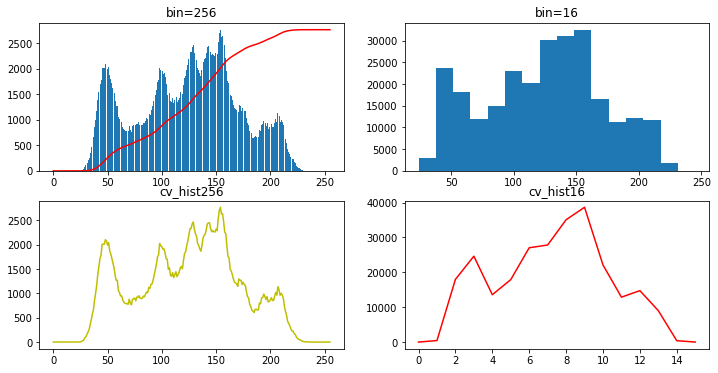

-1

In [45]:
import cv2
import matplotlib.pyplot as plt

o = cv2.imread('./image/lenaColor.png', 0)
cv2.imshow('original', o)
cv_hist256 = cv2.calcHist([o], [0], None, [256], [0,255])
cv_hist16 = cv2.calcHist([o], [0], None, [16], [0,255])

hist, bins = np.histogram(o.flatten(), 256, [0,256])  # 拉平
cdf = hist.cumsum()                                  # 累加 cdf : cumulate distribution function
cdf_normalized = cdf * hist.max()/ cdf.max()         # 標準化
print(hist.max(), cdf.max())

fig=plt.figure(figsize=(12, 6))
plt.subplot(221)  
plt.hist(o.ravel(), 256); plt.title('bin=256')       # ravel 將多維陣列轉換為一維陣列的功能 like flatten
plt.plot(cdf_normalized, color='r')                 # plot cdf

plt.subplot(222)  
plt.hist(o.ravel(), 16);  plt.title('bin=16')

plt.subplot(223)  
plt.plot(cv_hist256, color='y');  plt.title('cv_hist256')

plt.subplot(224)  
plt.plot(cv_hist16, color='r');  plt.title('cv_hist16')

plt.show()

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

### color image

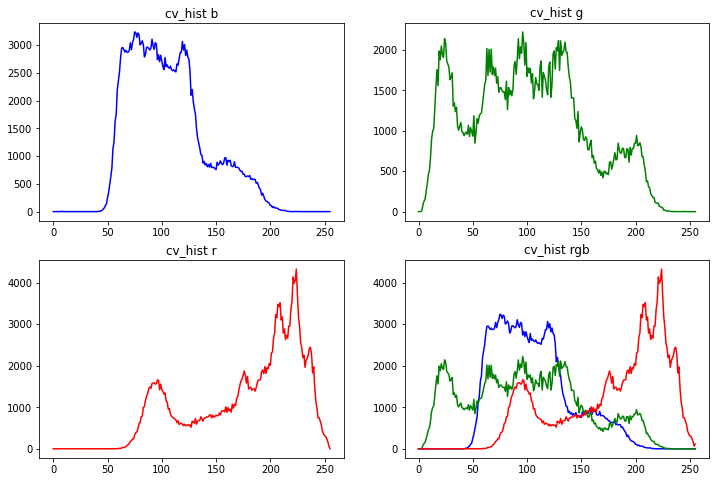

-1

In [46]:
import cv2
import matplotlib.pyplot as plt

o=cv2.imread('./image/lenaColor.png')
cv2.imshow('original', o)

cv_histb = cv2.calcHist([o], [0], None, [256], [0,255])   # [0] B
cv_histg = cv2.calcHist([o], [1], None, [256], [0,255])   # [1] G
cv_histr = cv2.calcHist([o], [2], None, [256], [0,255])   # [2] R

fig=plt.figure(figsize=(12, 8))

plt.subplot(221)  
plt.plot(cv_histb, color='b');  plt.title('cv_hist b')

plt.subplot(222)  
plt.plot(cv_histg, color='g');  plt.title('cv_hist g')

plt.subplot(223)  
plt.plot(cv_histr, color='r');  plt.title('cv_hist r')

color = ('b', 'g', 'r')
plt.subplot(224);  plt.title('cv_hist rgb')
for i, col in enumerate(color):
    histr = cv2.calcHist([o], [i], None, [256], [0, 256])
    plt.plot(histr, color = col)

plt.show()

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

### Gray Level 直方圖均衡化處理實例 Histogram Equalization (HE)
> 定義 : 通過拉伸影像的像素強度分佈範圍來``增強圖像對比度``，適用於``過曝或背光的圖片``<br>
> 缺點 : 對處理的數據不加選擇(全局處理)，如此一來``會增加背景雜訊的對比度``並且``降低有用訊號(特別亮或暗)的對比度``

經過比較可以發現均衡化後的圖像明亮的部分出現了``過曝``，失去了原本的細節。這是因為原圖整體暗的部份較多，而經過直方圖均衡化後使原本亮的地方更亮，

### gray level Histogram Equalization

262144


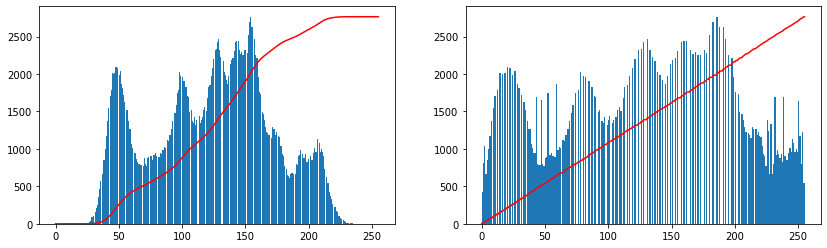

-1

In [47]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

o=cv2.imread('./image/lenaColor.png', 0)
equ=cv2.equalizeHist(o)

# cv2.imshow('original', o)
# cv2.imshow('equ', equ)
print(o.size)

hist, bins = np.histogram(o.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized_o = cdf * hist.max()/ cdf.max()

hist, bins = np.histogram(equ.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized_eq = cdf * hist.max()/ cdf.max()

fig=plt.figure(figsize=(14, 4))

plt.subplot(121)
plt.hist(o.ravel(), 256)
plt.plot(cdf_normalized_o, color='r')

plt.subplot(122)  
plt.hist(equ.ravel(), 256)
plt.plot(cdf_normalized_eq, color='r')

plt.show()
cv2.imshow('original', o)
cv2.imshow('gray_equ', equ)
cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

### Color 均衡化處理實例

In [48]:
import cv2
import numpy as np

img = cv2.imread('./image/lenaColor.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

equ = cv2.equalizeHist(gray)     # 灰度圖均衡化

result1 = np.hstack((gray, equ))  # 水平拼接原圖和均衡圖
cv2.imshow('grey_equ', result1)

(b, g, r) = cv2.split(img)        # 彩色影像均衡化,需要分解通道 對每一個通道均衡化
bH = cv2.equalizeHist(b)
gH = cv2.equalizeHist(g)
rH = cv2.equalizeHist(r)

equ2 = cv2.merge((bH, gH, rH))    # 合併每一個通道

result2 = np.hstack((img, equ2)) # 水平拼接原圖和均衡圖
cv2.imshow('bgr_equ', result2)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

### 自適應直方圖均衡 Adaptive Histogram Equalization AHE

> 為了提高影像的``區域性對比度``, 將影像分成``若干子塊對子塊進行HE處理``，這便是AHE（自適應直方圖均衡化）
它在每一個小區域內``（預設 8×8 ）``進行直方圖均衡化。當然，如果有噪點的話，噪點會被放大，需要對小區域內的對比度進行了限制。

> * 演算法 ：與一般的直方圖均衡 (全局) 相比，AHE 透過計算圖像每一個顯著``區域的直方圖``，重新分佈圖像的亮度值來改變影像對比度。
> * 優點 ：適合於改善影像的區域性對比度以及獲得更多的影像細節。
> * 缺點 ：在對比度增強的同時，也放大了影像的噪音，

>限制對比度自適應直方圖均衡 Contrast Limited Adaptive Histogram Equalization CLAHE
演算法 ：CLAHE與AHE都是局部均衡化，也就是把整個圖像分成許多小塊Tiles (OpenCV default為8×8)，對每個小塊進行均衡化。這種方法主要對於圖像直方圖不是那麼單一的圖像(e.g. 多峰情況)比較實用。所以在每一個的區域中，直方圖會集中在某一個小的區域中
> * clipLimit 參數表示對比度的大小。 
> * tileGridSize 參數表示每次處理塊的大小 。<br>

https://iter01.com/518513.html

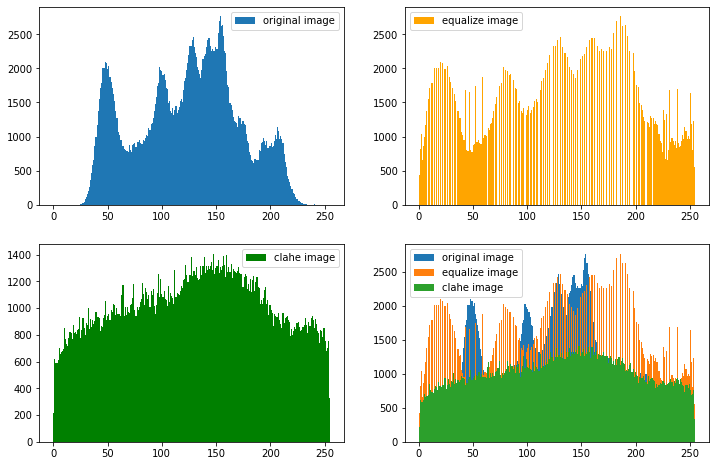

In [49]:
import cv2
import numpy as np

img = cv2.imread('./image/lenaColor.png', 0)

# 全域性直方圖均衡
equ = cv2.equalizeHist(img)

# 自適應直方圖均衡
clahe = cv2.createCLAHE(clipLimit = 40.0, tileGridSize = (8, 8))  # AHE   # default cliplimit  = 40 
cl1 = clahe.apply(img)

# 水平拼接三張影像
result1 = np.hstack((img, equ, cl1))

cv2.imshow('clahe_result.jpg', result1)
cv2.waitKey()
cv2.destroyAllWindows()

fig=plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.hist(img.ravel(), 256, [0, 255], label='original image'), plt.legend()

plt.subplot(222)
plt.hist(equ.ravel(), 256, [0, 255], label='equalize image', color='orange'), plt.legend()

plt.subplot(223)
plt.hist(cl1.ravel(), 256, [0, 255], label='clahe image', color='g'), plt.legend()

plt.subplot(224)
plt.hist(img.ravel(), 256, [0, 255], label='original image')
plt.hist(equ.ravel(), 256, [0, 255], label='equalize image')
plt.hist(cl1.ravel(), 256, [0, 255], label='clahe image')
plt.legend()

---

# Module 15. 視訊處理
> 介紹如何使用 OpenCV 擷取網路攝影機影像，處理與顯示即時的畫面影像，並將連續的畫面影像寫入影片檔案中儲存起來。網路攝影機的串流影像，可以透過 OpenCV 模組的 VideoCapture 影片擷取功能來達成，至於寫入影片檔則可使用 VideoWriter

## 15-1:視訊預覽
> 在準備擷取攝影機的影像之前，要先呼叫 cv2.VideoCapture 建立一個 VideoCapture 物件，這個 VideoCapture 物件會連接到一隻網路攝影機，我們可以靠著它的參數來指定要使用那一隻攝影機（0 代表第一隻、1 代表第二隻）。

> 建立好 VideoCapture 物件之後，就可以使用它的 read 函數來擷取一張張連續的畫面影像了。

> 在這個無窮迴圈中，每次呼叫 cap.read() 就會讀取一張畫面，其第一個傳回值 ret代表成功與否（True 代表成功，False 代表失敗），而第二個傳回值 frame 就是攝影機的單張畫面。

>### play video file or camera preview
> * cap = VideoCapture([index, file]) 開啟相機裝置 index, 視訊檔案 file
> * retval = VideoCapture.isOpened()  : True, False 判斷視訊捕獲是否初始化成功。初始化成功返回true
> * ret, frame = cap.read() : 
> * cap.release()

In [24]:
import numpy as np
import cv2

cap = cv2.VideoCapture('./video/chaplin.mp4')   # play video file
# cap = cv2.VideoCapture(0)                         # from camera
FPS = cap.get(cv2.CAP_PROP_FPS)               # frame per second
F_Count = cap.get(cv2.CAP_PROP_FRAME_COUNT)   # frame count
print(f'FPS : {FPS:.2f} ms, Frame_Count : {F_Count}')

while cap.isOpened():
    ret, frame = cap.read()
    
    frame = cv2.flip(frame, 1)   # left side right
    c=cv2.waitKey(30)            # 25 ms per frame     1/FPS

    if not ret or c==27:
        break
        
#     frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    cv2.imshow('frame',frame)

cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

FPS : 29.72 ms, Frame_Count : 172.0


-1

### Play video in jupyter lab

In [29]:
from IPython.display import HTML

HTML("""
    <video alt="test" controls>
        <source src="./video/chaplin.mp4" type="video/mp4">
    </video>
""")

## 15-2: 視訊讀寫

### imWrite : image writer
* cv2.WINDOW_NORMAL : ``可以`` 讓使用者改變視窗大小
* cv2.WINDOW_AUTOSIZE : 使用者 ``不可`` 改變視窗大小
* CAP_PROP_FRAME_WIDTH, CAP_PROP_FRAME_HEIGHT : 取的影像的長寬
* cv2.VideoCapture.set( propid, value )

|類別                       | propId | 說明                                  |
|---------------------------|:------:|---------------------------------------|
|cv2.CAP_PROP_POS_MSEC      | 0      | 視訊檔案的當前位置（ms）                |
|cv2.CAP_PROP_POS_FRAMES    | 1      | 從0開始索引幀，幀位置。                 |
|cv2.CAP_PROP_POS_AVI_RATIO | 2      | 視訊檔案的相對位置（0表示開始，1表示結束）|
|``cv2.CAP_PROP_FRAME_WIDTH``   | 3      | 視訊流的幀寬度                         |
|``cv2.CAP_PROP_FRAME_HEIGHT``  | 4      | 視訊流的幀高度                         |
|``cv2.CAP_PROP_FPS``           | 5      | 幀率                                  |
|``cv2.CAP_PROP_FOURCC``        | 6      | 編解碼器四字元程式碼                   |
|``cv2.CAP_PROP_FRAME_COUNT``   | 7      | 視訊檔案的幀數                         |
|cv2.CAP_PROP_FORMAT        | 8      | retrieve()返回的Mat物件的格式          |
|cv2.CAP_PROP_MODE          | 9      | 後端專用的值，指示當前捕獲模式           |
|cv2.CAP_PROP_BRIGHTNESS    | 10     | 影像的亮度，僅適用於支援的相機           |
|cv2.CAP_PROP_CONTRAST      | 11     | 影像對比度，僅適用於相機                |
|cv2.CAP_PROP_SATURATION    | 12     | 影像飽和度，僅適用於相機                 |
|cv2.CAP_PROP_HUE           | 13     | 影像色調，僅適用於相機                   |
|cv2.CAP_PROP_GAIN          | 14     | 影像增益，僅適用於支援的相機             |
|cv2.CAP_PROP_EXPOSURE      | 15     | 曝光，僅適用於支援的相機                 |
|cv2.CAP_PROP_CONVERT_RGB   | 16     | 布林標誌，指示是否應將影像轉換為RGB       |

### take 1 picture manually

In [31]:
import cv2
# import datetime as dt
from datetime import datetime as dt
now_dt = dt.now().strftime('%m/%d/%Y %H:%M:%S')

cv2.namedWindow('frame', cv2.WINDOW_NORMAL)
cap = cv2.VideoCapture('./video/chaplin.mp4')   # play video file
# cap = cv2.VideoCapture(0)                         # from camera

print(f'frame_w : {cap.get(cv2.CAP_PROP_FRAME_WIDTH)}')
print(f'frame_fps : {cap.get(cv2.CAP_PROP_FPS)}')
print(f'frame_count : {cap.get(cv2.CAP_PROP_FRAME_COUNT)}')

ratio = cap.get(cv2.CAP_PROP_FRAME_WIDTH) / cap.get(cv2.CAP_PROP_FRAME_HEIGHT)  # cap.get得到相機/視訊檔案的屬性
w = 500;  h = int(w / ratio)

cv2.resizeWindow('frame', w, h)       # change frame size
count=0
while True:
    ret, frame = cap.read()                          #  read frame : ret: True/ False,  frame:image
    frame = cv2.flip(frame, 1)                       # 0 : 上下左右顛倒,  -1 : 上下顛倒
    
    if cv2.waitKey(1)==ord('t') or cv2.waitKey(1)==ord('T'):
        cv2.putText(frame, now_dt, (100, 300), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_AA)
        cv2.imwrite(f'./image/frame{count}.jpg', frame)     # save frame as JPEG file          
        print(f'save image : frame{count}.jpg')
        count+=1 
        
    if not ret or cv2.waitKey(1) == 27:              # wait for 1 ms
        cap.release()
        cv2.destroyAllWindows()
        cv2.waitKey(1)        
        break   
        
    frame = cv2.resize(frame, (w, h))
    cv2.putText(frame, 'chaplin', (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_AA)

    cv2.imshow('frame', frame)

frame_w : 640.0
frame_fps : 29.719556780471343
frame_count : 172.0
save image : frame0.jpg


### capture 3 images from video

In [32]:
import cv2
from datetime import datetime as dt
now_dt = dt.now().strftime('%m/%d/%Y %H:%M:%S')

vidcap = cv2.VideoCapture('./video/chaplin.mp4')

success, image = vidcap.read()
count = 0
while success and count < 3:
    print('Read a new frame: ', success)
    success, image = vidcap.read()
    cv2.putText(image, now_dt+' cap 3', (100, 300), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_AA)
    cv2.imwrite("./image/frame%d.jpg" % count, image)     # save frame as JPEG file      
    print(f'Write a new frame: frame{count}.jpg')
    print('='*20)
    
    count += 1

Read a new frame:  True
Write a new frame: frame0.jpg
Read a new frame:  True
Write a new frame: frame1.jpg
Read a new frame:  True
Write a new frame: frame2.jpg


## 15-3: 視訊物件ROI, 追蹤和去背景

### track one obj in video file

In [2]:
import cv2

cap = cv2.VideoCapture('./video/vtest.avi')

# tracker = cv2.TrackerCSRT_create()

# tracker = cv2.TrackerBoosting_create()   # error
tracker = cv2.TrackerMIL_create()
# tracker = cv2.TrackerKCF_create()
# tracker = cv2.TrackerTLD_create()            # error
# tracker = cv2.TrackerMedianFlow_create()       # error
# tracker = cv2.TrackerGOTURN_create()          # error
# tracker = cv2.TrackerMOSSE_create()         # errro

roi = None
while True:
    ret, frame = cap.read()
 
    if roi is None:
        roi = cv2.selectROI('frame', frame)
        if roi != (0, 0, 0, 0):
            tracker.init(frame, roi)

    success, rect = tracker.update(frame)
    if success: 
        (x, y, w, h) = [int(i) for i in rect]
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0, 255, 0), 2)

    cv2.imshow('frame', frame)
    if cv2.waitKey(66) == 27:
        cv2.destroyAllWindows()
        cv2.waitKey(1)        
        break
cap.release()

### Track one obj in live Camera

In [1]:
import cv2, time

cap = cv2.VideoCapture(0)
tracker = cv2.TrackerCSRT_create()

# tracker = cv2.TrackerBoosting_create()   # error
# tracker = cv2.TrackerMIL_create()
# tracker = cv2.TrackerKCF_create()
# tracker = cv2.TrackerTLD_create()            # error
# tracker = cv2.TrackerMedianFlow_create()       # error
# tracker = cv2.TrackerGOTURN_create()          # error
# tracker = cv2.TrackerMOSSE_create()         # errro

roi = None
while True:
    ret, frame = cap.read()
    frame = cv2.flip(frame, 1)
    
    if roi is None:
        roi = cv2.selectROI('frame', frame)
        if roi != (0, 0, 0, 0):
            tracker.init(frame, roi)

    success, rect = tracker.update(frame)
    if success: 
        (x, y, w, h) = [int(i) for i in rect]
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0, 255, 0), 2)

    cv2.imshow('frame', frame)
    if cv2.waitKey(66) == 27:
        cv2.destroyAllWindows()
        cv2.waitKey(1)        
        break
cap.release()

### ROI (Region Of Interest) 只處理部分有興趣的

In [5]:
import cv2

# 指定 ROI 座標位置
RECT = ((320, 20), (570, 390))
(left, top), (right, bottom) = RECT

def roiarea(frame):                  # 取出 ROI 子畫面
    return frame[top:bottom, left:right]

def replaceroi(frame, roi):             # 將 ROI 區域貼回到原畫面
    frame[top:bottom, left:right] = roi
    return frame

cap = cv2.VideoCapture(0)               # 開啟攝影機, 讀取畫面
ratio = cap.get(cv2.CAP_PROP_FRAME_WIDTH) / cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

WIDTH = 800
HEIGHT = int(WIDTH / ratio)

while True:
    ret, frame = cap.read()
    frame = cv2.resize(frame, (WIDTH, HEIGHT))
    frame = cv2.flip(frame, 1)

    roi = roiarea(frame)                   # 取出子畫面
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)        # BGR to HSV
#     roi = cv2.cvtColor(roi, cv2.COLOR_BGR2XYZ)          # BGR to XYZ
    
    frame = replaceroi(frame, roi)         # 將處理完的子畫面貼回到原本畫面中
    
    cv2.rectangle(frame, RECT[0], RECT[1], (0,0,255), 2)      # 在 ROI 範圍處畫個框
    cv2.imshow('frame', frame)
    
    if cv2.waitKey(1) == 27: 
        cv2.destroyAllWindows()
        cv2.waitKey(1)        
        break
        
cap.release()

### framediff : 去背景 video

In [6]:
import cv2
cap = cv2.VideoCapture('./video/vtest.avi')
# cap = cv2.VideoCapture(0)

bg = None

while True:
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#     gray = cv2.GaussianBlur(gray, (17, 17), 0)       # 去雜訊
    if bg is None:
        bg = gray                                    # read gray which is inital image
        continue

    diff = cv2.absdiff(gray, bg)
    diff = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)[1]  # binary 後, 只有黑和白 (0, 1)
    diff = cv2.erode(diff, None, iterations=2)
    diff = cv2.dilate(diff, None, iterations=2)
#     diff = cv2.morphologyEx(diff,cv2.MORPH_OPEN, None, iterations=2)

    cnts, hierarchy = cv2.findContours(
        diff, 
        cv2.RETR_EXTERNAL,             # 若有重複, 只找外圈的
        cv2.CHAIN_APPROX_SIMPLE)       # 傳回特徵性座標, 如長 寬 高
    
    for c in cnts:
        if cv2.contourArea(c) < 500:    # try < 100  面積小於 500 不要 show 
            continue
            
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0), 2)

    cv2.imshow("frame", frame)
    if cv2.waitKey(100) == 27:
        cv2.destroyAllWindows()
        cv2.waitKey(1)        
        break
cap.release()

---

# Module 16. OpenCV 函式庫 DLib 介紹（Python）
> Dlib 使用的人臉偵測演算法是以方向梯度直方圖 Histogram of Oriented Gradients（HOG）的特徵加上線性分類器（linear classifier）、影像金字塔（image pyramid）與滑動窗格（sliding window）來實作的

## 16-1: DLib 影像辨識應用
> dlib 是一套包含了機器學習、計算機視覺、圖像處理等的函式庫，使用C++開發而成，目前廣泛使用於工業及學術界，也應用在機器人、嵌入式系統、手機、甚至於大型的運算架構中，而且最重要的是，它不但開源且完全免費，而且可跨平台使用（Linux、Mac OS、Windows），並且除了C++之外還提供了Python API ，因此如果我們想要建立一套物件偵測系統，dlib是相當適合的平台。

## 16-2: DLib 套件應用
> pip install dlib==19.8.1<br>
> ( or dlib-19.8.1-cp36-cp36m-win_amd64.whl ) (**python 3.6.8**)
## 16-3: DLib 特徵點描述

> ### 照片人臉偵測
> detector 函數的第二個參數是指定反取樣（unsample）的次數，如果圖片太小的時候，將其設為 1 可讓程式偵較容易測出更多的人臉。

In [16]:
import dlib
import cv2
# import imutils

# img = cv2.imread('./image/dlib.jpg')   # 讀取照片圖檔
img = cv2.imread('./image/faces02.png')

# img = imutils.resize(img, width=816)  # 縮小圖片

detector = dlib.get_frontal_face_detector()  # Dlib 的人臉偵測器

face_rects = detector(img, 1)   # try (img, 1)   # 偵測人臉
print(f'detected face numder : {len(face_rects)}')

# 取出所有偵測的結果
for i, d in enumerate(face_rects):
    x1 = d.left(); y1 = d.top(); x2 = d.right(); y2 = d.bottom()

    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 4, cv2.LINE_AA)  # 以方框標示偵測的人臉

cv2.imshow("Face Detection", img)     # 顯示結果

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

detected face numder : 9


-1

### 偵測結果與分數
>改用 detector.run 來偵測人臉，它的第三個參數是指定分數的門檻值，所有分數超過這個門檻值的偵測結果都會被輸出，而傳回的結果除了人臉的位置之外，還有分數（scores）與子偵測器的編號（idx），``子偵測器的編號可以用來判斷人臉的方向``，請參考 Dlib 的說明

In [6]:
import dlib
import cv2
# import imutils

img = cv2.imread('./image/dlib.jpg')
# img = cv2.imread('./image/faces02.png')

# img = imutils.resize(img, width=816)
detector = dlib.get_frontal_face_detector()

face_rects, scores, idx = detector.run(img, 0, -0)   # 偵測人臉，輸出分數
print(f'detected face numder : {len(face_rects)}')

for i, d in enumerate(face_rects):
    x1 = d.left(); y1 = d.top(); x2 = d.right(); y2 = d.bottom()
    text = "%2.2f(%d)" % (scores[i], idx[i])

    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 4, cv2.LINE_AA)
    cv2.putText(img, text, (x1, y1), cv2.FONT_HERSHEY_DUPLEX,       # 標示分數
          0.7, (255, 255, 255), 1, cv2.LINE_AA)

cv2.imshow("Face Detection", img)

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

detected face numder : 15


-1

### 影片人臉偵測
>FourCC是一個4位元組碼，用來確定視頻的編碼格式。<br>
FOURCC is short for "four character code" - an identifier for a video codec, compression format, color or pixel format used in media files.<br>
https://www.fourcc.org/codecs.php

In [17]:
import dlib
import cv2

cap = cv2.VideoCapture('./video/Alec_Baldwin_10s.mp4')    # 開啟影片檔案

width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))        # 取得畫面尺寸
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'XVID')             # 使用 XVID 編碼

# 建立 VideoWriter 物件，輸出影片至 output.avi，FPS 值為 20.0
out = cv2.VideoWriter('./video/Alec_Baldwin_face.mp4', fourcc, 20.0, (width, height))

detector = dlib.get_frontal_face_detector()          # Dlib 的人臉偵測器

while(cap.isOpened()):                              # 以迴圈從影片檔案讀取影格，並顯示出來
    ret, frame = cap.read()
    if ret :
        face_rects, scores, idx = detector.run(frame, 0, -.5)  # 偵測人臉

        for i, d in enumerate(face_rects):               # 取出所有偵測的結果
            x1 = d.left(); y1 = d.top(); x2 = d.right(); y2 = d.bottom()
            text = f'{scores[i]:.2f}, ({idx[i]:0.0f})'

            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 4, cv2.LINE_AA) # 以方框標示偵測的人臉
            cv2.putText(frame, text, (x1, y1), cv2.FONT_HERSHEY_DUPLEX,          # 標示分數
                        0.7, (255, 255, 255), 1, cv2.LINE_AA)

        out.write(frame)                               # 寫入影格
        cv2.imshow("Face Detection", frame)           # 顯示結果

    if cv2.waitKey(1) & 0xFF == 27:
        break
cap.release()
out.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

### 即時串流影像人臉偵測

In [12]:
import dlib
import cv2

cap = cv2.VideoCapture(0)   # 開啟影片檔案
detector = dlib.get_frontal_face_detector() # Dlib 的人臉偵測器

while(cap.isOpened()):               # 以迴圈從影片檔案讀取影格，並顯示出來
    ret, frame = cap.read()
    face_rects, scores, idx = detector.run(frame, 0)  # 偵測人臉

    for i, d in enumerate(face_rects):                  # 取出所有偵測的結果
        x1 = d.left(); y1 = d.top(); x2 = d.right(); y2 = d.bottom()
        text = f'{scores[i]:.2f}, ({idx[i]:0.0f})'

        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 4, cv2.LINE_AA) # 以方框標示偵測的人臉
        cv2.putText(frame, text, (x1, y1), cv2.FONT_HERSHEY_DUPLEX,    # 標示分數
            0.7, (255, 255, 255), 1, cv2.LINE_AA)

    cv2.imshow("Face Detection", frame)                      # 顯示結果
    if cv2.waitKey(1) & 0xFF == 27:
        break

cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

### 實現人臉68個關鍵點檢測
> dlib 也提供訓練好的模型，可以辨識出人臉的68的特徵點，68 特徵點包括鼻子、眼睛、眉毛，以及嘴巴等等，如上圖紅點就是偵測出人臉的68個特徵點。

><img src=".\image\dlib68.jpg"  style='height:250px; width:300px'>
><img src=".\image\dlib01.jpg"  style='height:250px; width:300px'><br>
><img src=".\image\dlib02.jpg"  style='height:250px; width:300px'>
><img src=".\image\dlib03.jfif"  style='height:250px; width:300px'>

In [18]:
import numpy as np
import cv2
import dlib

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(r'C:\Users\Tibame\TFB103\OpenCV\model\shape_predictor_68_face_landmarks.dat')
font = cv2.FONT_HERSHEY_SIMPLEX            # 利用cv2.putText輸出1-68

img = cv2.imread("./image/face68.JFIF")     # cv2讀取影像
# img = cv2.imread("./image/lenaColor.png")     # cv2讀取影像
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # 取灰度

rects = detector(img_gray, 0)             # 人臉數rects
for i in range(len(rects)):
    landmarks = np.matrix([[p.x, p.y] for p in predictor(img,rects[i]).parts()])
    for idx, point in enumerate(landmarks):
        
        pos = (point[0, 0], point[0, 1])   # 68點的座標
#         print(idx,pos)

        cv2.circle(img, pos, 5, color=(0, 255, 0)) # 利用cv2.circle給每個特徵點畫一個圈，共68個
        cv2.putText(img, str(idx+1), pos, font, 0.8, (0, 0, 255), 1,cv2.LINE_AA)

cv2.imshow("img", img)

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

### dlib - Obj detect
> * 先收集欲辨識的人正面照片 ( 甚至可以收集多角度照片 )於特定資料夾 (此處設為 ./dlib_ObjectCategories10)中，並將檔名設為人名。
> * 使用 dlib.get_frontal_face_detector() 擷取資料夾中照片的人臉，再利用 dlib.shape_predictor() 取出臉部 68 個關鍵點。
> * dlib.face_recognition_model_v1().compute_face_descriptor() 將 68 個關鍵點進行嵌入成一個 128 維的向量 ν1, ν2, ⋯。
> * 相同的方式將鏡頭中的人臉也嵌入成 128 維的向量 ν。
> * 計算 ν 與 ν1, ν2, ⋯ 個別計算歐式距離，最接近者及判定其身分。

#### download : 101_ObjectCategories.tar.gz (131Mbytes)
#### dlownload : Annotations.tar
http://www.vision.caltech.edu/Image_Datasets/Caltech101/

In [19]:
#匯入必要的library
# from __future__ import print_function
from scipy.io import loadmat
from skimage import io
import dlib
from imutils import paths

### loading

In [20]:
options = dlib.simple_object_detector_training_options()
images = [] # 存放相片圖檔
boxes = []  # 存放Annotations

# for imagePath in paths.list_images(args["class"]):
for imagePath in paths.list_images('./dlib_ObjectCategories10'):       #依序處理path下的每張圖片

    imageID = imagePath.split('\\')[1:]                 #從圖片路徑名稱中取出ImageID
    imageCat = imageID[1].split('.')[0].split('_')[1]
    
    p = f'./dlib_Annotations10/{imageID[0]}/annotation_{imageCat}.mat'   #載入Annotation
    annotations = loadmat(p)["box_coord"]
    #取出annotations資訊繪成矩形物件，放入boxes變數中。
#     (x, y, w, h) = (b.left(), b.top(), b.right(), b.bottom())
    
    bb = [dlib.rectangle(left=int(x), top=int(y), right=int(w), bottom=int(h)) for (y, h, x, w) in annotations]
#     bb = [dlib.rectangle(left=int(x), top=int(y), right=int(w), bottom=int(h)) for (x,y,w,h) in annotations]
    boxes.append(bb)

    images.append(io.imread(imagePath))          #將圖片放入images變數
print('done', len(images), len(boxes))

done 105 105


### training

In [21]:
#丟入三個參數開始訓練

print("[INFO] training detector...")
detector = dlib.train_simple_object_detector(images, boxes, options)
 
# 將訓練結果匯出到檔案
print("[INFO] dumping classifier to file...")
detector.save('./dlib_output/model.svm')
 
# 圖形化顯示 Histogram of Oriented Gradients（簡稱HOG）
win = dlib.image_window()
win.set_image(detector)
dlib.hit_enter_to_continue()

[INFO] training detector...
[INFO] dumping classifier to file...


### detect

In [22]:
import dlib
import cv2
from imutils import paths
#載入訓練好的detector
# detector = dlib.simple_object_detector(detector)
 
#載入測試圖片逐張進行
for idx, testingPath in enumerate(paths.list_images('./dlib_ObjectCategories10/accordion')):
# for idx, testingPath in enumerate(paths.list_images('./dlib_ObjectCategories10/camera')):
#讀取圖片並執行dector並產生矩形物件以便用於標記辨識出的部份
    image = cv2.imread(testingPath)
    boxes = detector(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    for b in boxes:                    #在圖片上繪出該矩形
        (x, y, w, h) = (b.left(), b.top(), b.right(), b.bottom())
        cv2.rectangle(image, (x, y), (w, h), (0, 255, 0), 2)

    cv2.imshow(str(idx), image)         #顯示圖片
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

---

# Module 17. OCR 光學字元識別

## 17-1 OCR 介紹(Optical Character Recognition)
> OCR 為光學文字識別的縮寫（Optical Character Recognition，OCR），就是將``圖片翻譯為文字``。而 Tesseract 是一個 OCR 模組，目前由 Google 贊助。Tesseract 已經有 30 年歷史，一開始它是惠普實驗室的一款專利軟體，於 2005 年開源，從 2006 年後由 Google 贊助進行後續的開發和維護, Tesseract 也是目前公認最優秀、最精準的開源 OCR 系統

> Tesseract目前已作為開源項目發佈在Google Project，其最新版本3.0已經``支持中文OCR``，並提供了一個命令行工具。
主要使用在辨識掃描文件/圖片的文字。

>除了極高的精準度外，Tesseract 也有很高的靈活性，能夠通過訓練識別出任何字體（只要這些字體的風格不變就可以），也能識別出任何 Unicode 字符，是不是非常厲害呢？我們待會會用到的 pytesseract 模組就像是Tesseract的 python 包裝器。

><img src=".\image\OCR1.png"  style='height:300px; width:600px'>
><img src=".\image\OCR2.png"  style='height:300px; width:600px'>
><img src=".\image\OCR.jpeg"  style='height:350px; width:600px'>

## 17-2 Tesseract 安裝

> * pip install pytesseract
> * https://github.com/UB-Mannheim/tesseract/wiki <br>
>> (download : tesseract-ocr-w64-setup-v..........exe)
> * run : tesseract-ocr-w64-setup-v5.0.0-alpha.20201127.exe
> * 安裝好後找到 tesseract.exe 的位置，並複製其絕對路徑，通常會在<br>
>> C:\Program Files\Tesseract-OCR\tesseract.exe。

> 到此網站下載中文的語言辨識包

>> https://github.com/tesseract-ocr/tessdata_best<br>
>> — chi_sim.traineddata → 簡體中文包<br>
>> — chi_tra.traineddata → 繁體中文包

>>下載後並將檔案放到 : C:\Program Files\Tesseract-OCR\tessdata\ 中，

In [24]:
!pip install pytesseract

  Created wheel for pytesseract: filename=pytesseract-0.3.8-py2.py3-none-any.whl size=14072 sha256=97635cfa75a37425ab229c12791d0b751e42d00f16c0b4e35f2231b3f6fcd6c7
  Stored in directory: c:\users\tibame\appdata\local\pip\cache\wheels\c6\3a\30\877d14dc50fb68f107b18247a31db742518c6f74f64de8dde8
Successfully built pytesseract


### run 下列指令確保 tesseract 安裝成功

In [2]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
pytesseract.get_tesseract_version()

LooseVersion ('5.0.0-alpha.20210811
 leptonica-1.78.0
  libgif 5.1.4 : libjpeg 8d (libjpeg-turbo 1.5.3) : libpng 1.6.34 : libtiff 4.0.9 : zlib 1.2.11 : libwebp 0.6.1 : libopenjp2 2.3.0
 Found AVX2
 Found AVX
 Found FMA
 Found SSE4.1
 Found libarchive 3.5.0 zlib/1.2.11 liblzma/5.2.3 bz2lib/1.0.6 liblz4/1.7.5 libzstd/1.4.5
 Found libcurl/7.77.0-DEV Schannel zlib/1.2.11 zstd/1.4.5 libidn2/2.0.4 nghttp2/1.31.0
')

## 17-3 實作光學字元辨識

### English

In [6]:
import pytesseract
import cv2

img = cv2.imread('./image/tess01.jpeg', 0)
# img=cv2.resize(img, (650, 850))

# img = cv2.imread('./image/starbucks.jpg', 0)
# img=cv2.resize(img, (850, 650))

# img = cv2.imread('./image/CarPlate1.jpg', 0)   # CarPlate1, 2
# img = cv2.imread('./image/CarPlate2.jpg', 0)   # CarPlate1, 2
# img = cv2.imread('./image/CarPlate3.jpg', 0)   # CarPlate1, 2
img=cv2.resize(img, (350, 350))

cv2.imshow('original', img)

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
text = pytesseract.image_to_string(img, lang='eng')  # chi_tra, chi_sim 修改 lang 參數變就可以
print(text.split())

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

['IWwG', 'Women', '&', 'Sport', 'ERS', 'acs', 'mecearios', 'te', 'Neue', 'Zale']


-1

### Chi_tri : OCR 辨識繁體中文

> OCR 識別提取圖片中文字原理

> * 預處理：在這個步驟通常有：灰度化（如果是彩色影像）、降噪、二值化、字元切分以及歸一化這些子步驟。
>> * 經過二值化後，影像只剩下兩種顏色，即黑和白，其中一個是影像背景，另一個顏色就是要識別的文字了。
>> * 降噪在這個階段非常重要，降噪演算法的好壞對特徵提取的影響很大。
>> * 字元切分則是將影像中的文字分割成單個文字——識別的時候是一個字一個字識別的。如果文字行有傾斜的話往往還要進行傾斜校正。
>> * 歸一化則是將單個的文字影像規整到同樣的尺寸，在同一個規格下，才能應用統一的演算法。

> * 特徵提取和降維：對於漢字來說，特徵提取比較困難，因為首先漢字是大字符集，漢字中光是最常用的
>> * 第一級漢字就有3755個
>> * 第二漢字結構複雜，形近字多。

>> 在確定了使用何種特徵後，視情況而定，還有可能要進行特徵降維，這種情況就是如果特徵的維數太高（特徵一般用一個向量表示，維數即該向量的分量數），分類器的效率會受到很大的影響，為了提高識別速率，往往就要進行降維，這個過程也很重要，既要降低維數吧，又得使得``減少維數後的特徵向量還保留了足夠的資訊量``（以區分不同的文字）。
>分類器設計、訓練和實際識別：分類器是用來進行識別的，就是對於第二步，對一個文字影像，提取出特徵給，丟給分類器，分類器就對其進行分類，告訴你這個特徵該識別成哪個文字。

> * 後處理：後處理是用來對分類結果進行優化的，
>> * 第一個，分類器的分類有時候不一定是完全正確的（實際上也做不到完全正確），比如對漢字的識別，由於漢字中形近字的存在，很容易將一個字識別成其形近字。後處理中可以去解決這個問題，比如通過語言模型來進行校正——如果分類器將“在哪裡”識別成“存哪裡”，通過``語言模型``會發現“存哪裡”是錯誤的，然後進行校正。
>> * 第二個，OCR的識別影像往往是有大量文字的，而且這些文字存在排版、字型大小等複雜情況，後處理中可以嘗試去對識別結果進行格式化，比如按照影像中的排版排列什麼的，舉個例子，一張影像，其左半部分的文字和右半部分的文字毫無關係，而在字元切分過程中，往往是按行切分的，那麼識別結果中左半部分的第一行後面會跟著右半部分的第一行諸如此類。

In [2]:
import pytesseract
import cv2

# img = cv2.imread('./image/OCR7.jpg', 0)
img = cv2.imread('./image/tess02.jpg', 0)
# img = cv2.imread('C:/Users/Tibame/Pictures/Screenshots/321.jpg', 0)
# img1=cv2.resize(img, (650, 850))
cv2.imshow('original', img)

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
text = pytesseract.image_to_string(img, lang='chi_tra')  # try : chi_tra+eng, chi_sim
print(text.replace(' ', ''))

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

「春遊浩蕩.是年年寒食.梨花時節。‧白錦無紋香爛漫.玉樹殉苞堆雪‧靜夜深沉.浮光
霧志.冷浸溶溶月。人間天上.爛銀起照通微。潭似姑射真人.天姿靈秀.意氣殊高潔‧萬世
參差誰信道.不與群芳同列.浩氣清英.仙才卓華.下土難分別‧瑤台歸去.洞天方看清
絕。,

作這一首《無俗念》詞的.乃南宋末年一位武學名家.有道之士‧此人姓丘.名處機,道
號長春子.名列全真七子之一.是全真教中出類拔萃的人物。《詞品》評論此詞道:「長春,
世之所謂仙人也.而詞之清拔如此」。這首詞誦的似是梨花.其實詞中真意卻是讚譽一位身穿
白衣的美貌少女,說她「渾似姑射真人.天次靈秀.意氣殊高潔.又說她「浩氣清英.仙才
卓華」.「不與群芳同列」‧詞中所領這美女.乃古墓派傳人小龍女‧她一生愛穿白衣,當真
如風拂玉樹.雪裹尬苞.兼之生性清冷.實當得起「冷浸溶溶月」的形容.以「無俗念」三字
贈之.可說十分貼切。‧長春子丘處機和她在終南山上比鄰而居.當年一見.便寫下這首詞來。



這時丘處機逝世已久.小龍女也已嫁與神鵰大俠楊過為妻‧在河南少室山山道之上.卻另
有一個少女.正在低低念誦此詞‧這少女十八九歲年紀.身穿淡黃衣衫.騎著一頭青驢.正沿
山道緩緩而上.心中默想:「也只有龍姊姊這樣的人物.才配得上他。」這一個「他」字.指
的自然是神肉大俠楊過了。她也不拉梭總.任由那青驢信步而行,一路上山‧過了良久.她又
低聲吟道:「歡樂趣.離別苦.就中更有痴兒女‧君應有語.渺萬裡層雲.千山暮雪.隻影向
誰去?」



-1

In [6]:
text.replace(" ", '').replace('.', ', ').replace('\n', '').replace('\x0c','')

'「春遊浩蕩, 是年年寒食, 梨花時節。‧白錦無紋香爛漫, 玉樹殉苞堆雪‧靜夜深沉, 浮光霧志, 冷浸溶溶月。人間天上, 爛銀起照通微。潭似姑射真人, 天姿靈秀, 意氣殊高潔‧萬世參差誰信道, 不與群芳同列, 浩氣清英, 仙才卓華, 下土難分別‧瑤台歸去, 洞天方看清絕。,作這一首《無俗念》詞的, 乃南宋末年一位武學名家, 有道之士‧此人姓丘, 名處機,道號長春子, 名列全真七子之一, 是全真教中出類拔萃的人物。《詞品》評論此詞道:「長春,世之所謂仙人也, 而詞之清拔如此」。這首詞誦的似是梨花, 其實詞中真意卻是讚譽一位身穿白衣的美貌少女,說她「渾似姑射真人, 天次靈秀, 意氣殊高潔, 又說她「浩氣清英, 仙才卓華」, 「不與群芳同列」‧詞中所領這美女, 乃古墓派傳人小龍女‧她一生愛穿白衣,當真如風拂玉樹, 雪裹尬苞, 兼之生性清冷, 實當得起「冷浸溶溶月」的形容, 以「無俗念」三字贈之, 可說十分貼切。‧長春子丘處機和她在終南山上比鄰而居, 當年一見, 便寫下這首詞來。這時丘處機逝世已久, 小龍女也已嫁與神鵰大俠楊過為妻‧在河南少室山山道之上, 卻另有一個少女, 正在低低念誦此詞‧這少女十八九歲年紀, 身穿淡黃衣衫, 騎著一頭青驢, 正沿山道緩緩而上, 心中默想:「也只有龍姊姊這樣的人物, 才配得上他。」這一個「他」字, 指的自然是神肉大俠楊過了。她也不拉梭總, 任由那青驢信步而行,一路上山‧過了良久, 她又低聲吟道:「歡樂趣, 離別苦, 就中更有痴兒女‧君應有語, 渺萬裡層雲, 千山暮雪, 隻影向誰去?」'

--- 

### Tesseract 命令列參數最重要的三個是 -l, --oem, --psm。
> * -l ：控制輸入文本的語言，用 eng 表示英文（預設語言），用 chi_sim 表示中文簡體，用 chi_tra 表示中文繁體。
> * --oem ：OCR Engine modes，Tesseract 有兩個OCR引擎，使用 -oem 選擇演算法類型，有四種操作模式可供選擇。

|值 |說明                                 |
|---|------------------------------------|
| 0 |Legacy engine only                  |
| 1 |Neural nets LSTM engine only        |
| 2 |Legacy + LSTM engines               |
| 3 |Default, based on what is available |

>> 用 --oem 1 表示我們希望只使用LSTM neural network。
> * --psm：Page segmentation modes，控制 Tesseract 使用的自動頁面分割模式。

>> Page segmentation modes:

|值 |說明                                                              |
|---|------------------------------------------------------------------|
| 0 |Orientation and script detection (OSD) only                       |
| 1 |Automatic page segmentation with OSD                              |
| 2 |Automatic page segmentation, but no OSD, or OCR (not implemented) |
| 3 |Fully automatic page segmentation, but no OSD (Default)           |
| 4 |Assume a single column of text of variable sizes                  |
| 5 |Assume a single uniform block of vertically aligned text          |
| 6 |Assume a single uniform block of text                             |
| 7 |Treat the image as a single text line                             |
| 8 |Treat the image as a single word                                  |
| 9 |Treat the image as a single word in a circle                      |
| 10| Treat the image as a single character                            |
| 11| Sparse text. Find as much text as possible in no particular order|
| 12| Sparse text with OSD                                             |
| 13| Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.|


In [4]:
import cv2 
import pytesseract

img = cv2.imread('./image/tess01.jpeg', 0)
img=cv2.resize(img, (650, 850))

# Adding custom options
custom_config = r'--oem 3 --psm 3'
text = pytesseract.image_to_string(img, config=custom_config)
print(text)

cv2.imshow('img', img)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

TesseractNotFoundError: tesseract is not installed or it's not in your PATH. See README file for more information.

### image_to_boxes 返回包含已識別字元及其框邊界的結果

In [9]:
import cv2
import pytesseract

img = cv2.imread('./image/tess01.jpeg')
img=cv2.resize(img, (650, 850))

h, w, c = img.shape
boxes = pytesseract.image_to_boxes(img) 
for b in boxes.splitlines():
    b = b.split(' ')
    img = cv2.rectangle(img, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)

cv2.imshow('img', img)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

### image_to_data 定位圖片中的文字，以及該函數輸出資料的格式詳解, 包含框邊界，置信度和其他資訊的結果

In [3]:
import cv2
import pytesseract
from pytesseract import Output

img = cv2.imread('./image/tess01.jpeg')
img=cv2.resize(img, (650, 850))
d = pytesseract.image_to_data(img, output_type=Output.DICT)
print(d.keys())
print(d)

TesseractNotFoundError: tesseract is not installed or it's not in your PATH. See README file for more information.

### text key in dict

In [ ]:
n_boxes = len(d['text'])
for i in range(n_boxes):
    if float(d['conf'][i]) > 60:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        img = cv2.rectangle(img, (int(x), int(y)), (int(x) + int(w), int(y) + int(h)), (0, 255, 0), 2)

cv2.imshow('img', img)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

---

# Module 18. 人臉辨識

## 18-1: 人臉偵測介紹
> 一張臉, 可能會有超過 6000 個 classifiers. 如果要辨識一張圖裡面有幾張人臉, 不就等於是要把圖裡面的全部區塊, 都分別跑完 6000 個 classifiers 比對. 這會需要很多很多的運算資源與時間. 

> Cascades (瀑布式) 是把人臉辨識的 6000 個 classifiers 分成數個階段. 比對圖區塊時, 都從第一個階段做辨識, 若沒通過就淘汱不用往下做, 有通過 (可能是臉) 才繼續做下階段的辨識, 直到通過全部的辨識, 才判斷為人臉. 這種類似瀑布一段一段往下做法的好處是~ 節省運算資源與時間, 不用每個圖區塊都得做足 6000 個辨識.

> ### HaarCascade
><img src=".\image\haar.jpg"  style='height:200px; width:600px'></img>
><img src=".\image\haar01.png"  style='height:200px; width:600px'></img>
><img src=".\image\haar02.jpg"  style='height:200px; width:600px'></img>
><img src=".\image\haar03.jpg"  style='height:200px; width:600px'></img><br>
>C:\Program Files\Python36\Lib\site-packages\cv2\data
## 18-2: 人臉辨識介紹

> ### LBPH
> 原始的LBP (Local Binary Patterns，局部二值模式算子) 定義為在 3x3 的窗口內，以窗口中心像素為閾值，將相鄰的8個像素的灰度值與其進行比較，若周圍像素值大於或等於中心像素值，則該像素點的位置被標記為1，否則為0。這樣，3x3 鄰域內的8個點經比較可產生 8 位二進位數(通常轉換為十進位數即 LBP 碼，共256種)，即得到該窗口中心像素點的 LBP 值，並用這個值來反映該區域的紋理特徵。如下圖所示：
><img src=".\image\LBPH.png"  style='height:150px; width:600px'></img>

> ### 圓形 LBP 算子
> 基本的 LBP 算子的最大缺陷在於它只覆蓋了一個固定半徑範圍內的小區域，這顯然不能滿足不同尺寸和頻率紋理的需要。為了適應不同尺度的紋理特徵，Ojala 等對 LBP 算子進行了改進，將 3×3 鄰域擴展到任意鄰域，並用圓形鄰域代替了正方形鄰域，改進後的 LBP 算子允許在半徑為 R 的圓形鄰域內有任意多個像素點，從而得到了諸如半徑為R的圓形區域內含有 P 個採樣點的 LBP 算子， OpenCV 中正是使用圓形 LBP 算子，下圖示意了圓形 LBP 算子：<br>
><img src=".\image\LBPH01.png"  style='height:200px; width:600px'></img>

> ### 旋轉不變模式
> 是不斷旋轉圓形鄰域得到一系列初始定義的 LBP值，``取其最小值作為該鄰域的 LBP 值``。

> 從 LBP 的定義可以看出，LBP 算子是灰度不變的，但卻不是旋轉不變的，圖像的旋轉就會得到不同的 LBP 值。Maenpaa 等人又將 LBP 算子進行了擴展，提出了具有旋轉不變性的 LBP 算子，即不斷旋轉圓形鄰域得到一系列初始定義的 LBP 值，取其最小值作為該鄰域的 LBP 值。下圖給出了求取旋轉不變 LBP 的過程示意圖，圖中算子下方的數字表示該算子對應的 LBP 值，圖中所示的 8 種 LBP 模式，經過旋轉不變的處理，最終得到的具有旋轉不變性的 LBP 值為 15。也就是說，圖中的 8 種 LBP模式對應的旋轉不變的 LBP 碼值都是 00001111。

><img src=".\image\LBP03.jpg"  style='height:250px; width:500px'></img>

## 18-3: OpenCV 實作人臉辨識

> Cascade classifier for Haar features 有很多種類; 人臉, 眼睛, 耳朵, 嘴... 甚至可以自己訓練一套專屬用途的.

> haar cascades 資源

> * haarcascade_frontalface_default.xml → 人臉
> * haarcascade_eye_tree_eyeglasses.xml → 眼睛
> * haarcascade_frontalface_alt_tree.xml
> * haarcascade_frontalface_alt.xml
> * haarcascade_frontalface_alt2.xml

### conda envs path :
>##### C:\Users\Tibame\anaconda3\envs\opencv\Lib\site-packages\cv2\data

In [14]:
import cv2
# haarcascade_frontalface_default.xml  人臉正面與側面
# face_cascade = cv2.CascadeClassifier('C:\Program Files\Python36\Lib\site-packages\cv2\data\haarcascade_frontalface_default.xml')

# haarcascade_frontalface_alt2.xml     人臉正面效果較好
# face_cascade = cv2.CascadeClassifier('C:\Program Files\Python36\Lib\site-packages\cv2\data\haarcascade_frontalface_alt2.xml')

# haarcascade_profileface.xml         人臉側面效果較好
# face_cascade = cv2.CascadeClassifier('C:\Program Files\Python36\Lib\site-packages\cv2\data\haarcascade_profileface.xml')

# haarcascade_eye.xml                 眼睛偵測
face_cascade = cv2.CascadeClassifier(r'C:\Users\Tibame\anaconda3\envs\opencv\Lib\site-packages\cv2\data\haarcascade_eye.xml')

# image = cv2.imread('./image/faces.jpg')
# image = cv2.imread('./image/faces.png')
image = cv2.imread('./image/faces01.jpg')
# image = cv2.imread('./image/faces02.png')
image=cv2.resize(image, (800, 600))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray, 1.2, 5, minSize=(5, 5), maxSize=(100, 100))   # image, scaleFactor=1.1, minNeighbor=6
# faces = face_cascade.detectMultiScale(gray, 1.05, 4)   # 參數調整
print(faces)
print(f'find {len(faces)} faces in image ')
for (x, y, w, h) in faces:
    image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 3)

# cv2.namedWindow('video', cv2.WINDOW_NORMAL)
cv2.imshow('result', image)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

[[335  89  32  32]
 [566  93  27  27]
 [622  90  34  34]
 [389  86  39  39]
 [161 273  32  32]
 [395 288  23  23]
 [550 281  36  36]
 [ 99 266  43  43]
 [604 280  40  40]
 [332 288  22  22]
 [326 472  39  39]
 [385 471  42  42]
 [155 485  28  28]
 [ 97 485  24  24]
 [571 487  35  35]
 [634 498  27  27]
 [148  78  39  39]]
find 17 faces in image 


-1

### capture images from video

In [6]:
import cv2, time
n = 1       # 存檔檔名用
index = 0   # 人臉取樣總數
total = 100

def saveImage(face_image, index):
    filename = '.\image\h0\{:02d}.jpg'.format(index)
    cv2.imwrite(filename, face_image)

    print(filename)

face_cascade = cv2.CascadeClassifier(r'C:\Users\Tibame\anaconda3\envs\opencv\Lib\site-packages\cv2\data\haarcascade_frontalface_default.xml')
cap = cv2.VideoCapture(0)
cv2.namedWindow('video', cv2.WINDOW_NORMAL)
time.sleep(3)

while n > 0:
    ret, frame = cap.read()
#     frame = cv2.resize(frame, (600, 336))
    frame = cv2.flip(frame, 1)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, 1.1, 3)
    for (x, y, w, h) in faces:
        frame = cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 3)
        if n % 3 == 0:
            face_image = cv2.resize(gray[y: y + h, x: x + w], (400, 400))
            saveImage(face_image, index)

            index += 1
            if index >= total:
                print('get training data done')
                n = -1
                break
        n += 1
    cv2.imshow('video', frame)
#     cv2.waitKey(0)
    if cv2.waitKey(1) == 27:
        cap.release()
        cv2.destroyAllWindows()
        cv2.waitKey(1)        
        break

.\image\h0\00.jpg
.\image\h0\01.jpg
.\image\h0\02.jpg
.\image\h0\03.jpg
.\image\h0\04.jpg
.\image\h0\05.jpg
.\image\h0\06.jpg
.\image\h0\07.jpg
.\image\h0\08.jpg
.\image\h0\09.jpg
.\image\h0\10.jpg
.\image\h0\11.jpg
.\image\h0\12.jpg
.\image\h0\13.jpg
.\image\h0\14.jpg
.\image\h0\15.jpg
.\image\h0\16.jpg
.\image\h0\17.jpg
.\image\h0\18.jpg
.\image\h0\19.jpg
.\image\h0\20.jpg
.\image\h0\21.jpg
.\image\h0\22.jpg
.\image\h0\23.jpg
.\image\h0\24.jpg
.\image\h0\25.jpg
.\image\h0\26.jpg
.\image\h0\27.jpg
.\image\h0\28.jpg
.\image\h0\29.jpg
.\image\h0\30.jpg
.\image\h0\31.jpg
.\image\h0\32.jpg
.\image\h0\33.jpg
.\image\h0\34.jpg
.\image\h0\35.jpg
.\image\h0\36.jpg
.\image\h0\37.jpg
.\image\h0\38.jpg
.\image\h0\39.jpg
.\image\h0\40.jpg
.\image\h0\41.jpg
.\image\h0\42.jpg
.\image\h0\43.jpg
.\image\h0\44.jpg
.\image\h0\45.jpg
.\image\h0\46.jpg
.\image\h0\47.jpg
.\image\h0\48.jpg
.\image\h0\49.jpg
.\image\h0\50.jpg
.\image\h0\51.jpg
.\image\h0\52.jpg
.\image\h0\53.jpg
.\image\h0\54.jpg
.\image\h0

### train 1 dir/ obj
LBPH : https://kknews.cc/zh-tw/tech/2mz68e.html

In [7]:
import cv2
import numpy as np
n = 1       # 存檔檔名用
index = 0   # 人臉取樣總數
total = 100

images = []; labels = []
for index in range(total):
    filename = './image/h0/{:02d}.jpg'.format(index)
#     print('read ' + filename)
    img = cv2.imread(filename, cv2.COLOR_BGR2GRAY)
    if isinstance(img, np.ndarray):                     # if existed, append....
        print('read ' + filename+' done')
        images.append(img)
        labels.append(0)    # 第一張人臉的標籤為0
    else :
        print('read ' + filename+' not exists')

print('training...')
model = cv2.face.LBPHFaceRecognizer_create(radius=1, neighbors=8)
model.train(np.asarray(images), np.asarray(labels))      # train 只接受 numpy array
model.save('./model/faces.data')
print('training done')

read ./image/h0/00.jpg done
read ./image/h0/01.jpg done
read ./image/h0/02.jpg done
read ./image/h0/03.jpg done
read ./image/h0/04.jpg done
read ./image/h0/05.jpg done
read ./image/h0/06.jpg done
read ./image/h0/07.jpg done
read ./image/h0/08.jpg done
read ./image/h0/09.jpg done
read ./image/h0/10.jpg done
read ./image/h0/11.jpg done
read ./image/h0/12.jpg done
read ./image/h0/13.jpg done
read ./image/h0/14.jpg done
read ./image/h0/15.jpg done
read ./image/h0/16.jpg done
read ./image/h0/17.jpg done
read ./image/h0/18.jpg done
read ./image/h0/19.jpg done
read ./image/h0/20.jpg done
read ./image/h0/21.jpg done
read ./image/h0/22.jpg done
read ./image/h0/23.jpg done
read ./image/h0/24.jpg done
read ./image/h0/25.jpg done
read ./image/h0/26.jpg done
read ./image/h0/27.jpg done
read ./image/h0/28.jpg done
read ./image/h0/29.jpg done
read ./image/h0/30.jpg done
read ./image/h0/31.jpg done
read ./image/h0/32.jpg done
read ./image/h0/33.jpg done
read ./image/h0/34.jpg done
read ./image/h0/35.j

### train 2 or more dir/ obj
LBPH, Eigen, Fisher

In [8]:
import os
import cv2
import numpy as np

images = []; labels = []

path='.\image'
for objname in os.listdir(path):
    fullname= os.path.join(path, objname)
#     print(fullname)
    if os.path.isdir(fullname) and objname[0] == 'h' :
#         print(fullname, objname)
        for pict in os.listdir(fullname):
#             print(fullname+'\\'+pict)
            img = cv2.imread(fullname+'\\'+pict, cv2.COLOR_BGR2GRAY)
            print('read ' + fullname+'\\'+pict+' done ,  ', 'object/ label : ', objname)
            images.append(img)
            labels.append(int(objname[-1]))                                # 第一張人臉的標籤為
            
print('training...')
model = cv2.face.LBPHFaceRecognizer_create()
# model = cv2.face.EigenFaceRecognizer_create()
# model = cv2.face.FisherFaceRecognizer_create()
model.train(np.asarray(images), np.asarray(labels))
model.save('./model/faces.data')
print('training done', model)

read .\image\h0\00.jpg done ,   object/ label :  h0
read .\image\h0\01.jpg done ,   object/ label :  h0
read .\image\h0\02.jpg done ,   object/ label :  h0
read .\image\h0\03.jpg done ,   object/ label :  h0
read .\image\h0\04.jpg done ,   object/ label :  h0
read .\image\h0\05.jpg done ,   object/ label :  h0
read .\image\h0\06.jpg done ,   object/ label :  h0
read .\image\h0\07.jpg done ,   object/ label :  h0
read .\image\h0\08.jpg done ,   object/ label :  h0
read .\image\h0\09.jpg done ,   object/ label :  h0
read .\image\h0\10.jpg done ,   object/ label :  h0
read .\image\h0\11.jpg done ,   object/ label :  h0
read .\image\h0\12.jpg done ,   object/ label :  h0
read .\image\h0\13.jpg done ,   object/ label :  h0
read .\image\h0\14.jpg done ,   object/ label :  h0
read .\image\h0\15.jpg done ,   object/ label :  h0
read .\image\h0\16.jpg done ,   object/ label :  h0
read .\image\h0\17.jpg done ,   object/ label :  h0
read .\image\h0\18.jpg done ,   object/ label :  h0
read .\image

### 3recognition
> LBPH 愈低愈好, 低於 50 可接受

In [15]:
import cv2

model = cv2.face.LBPHFaceRecognizer_create()     # 要與 train 時的演算法一致 
# model = cv2.face.EigenFaceRecognizer_create()     # 要與 train 時的演算法一致 
# model = cv2.face.FisherFaceRecognizer_create()     # 要與 train 時的演算法一致 
model.read('./model/faces.data')
print('load training data done')

face_cascade = cv2.CascadeClassifier(r'C:\Users\Tibame\anaconda3\envs\opencv\Lib\site-packages\cv2\data\haarcascade_frontalface_default.xml')

# haarcascade_frontalface_alt2.xml     人臉正面效果較好
# face_cascade = cv2.CascadeClassifier(r'C:\Users\Tibame\anaconda3\envs\opencv\Lib\site-packages\cv2\data\haarcascade_frontalface_alt2.xml')

# face_cascade = cv2.CascadeClassifier(r'C:\Users\Tibame\anaconda3\envs\opencv\Lib\site-packages\cv2\data\haarcascade_eye.xml')

# cap = cv2.VideoCapture(0)
cap = cv2.VideoCapture('TFB103-14倪睿謙opencv.mp4')
# 可識別化名稱
names = ['Ni']

while True:
    ret, frame = cap.read()
#     frame = cv2.resize(frame, (600, 336))
    frame = cv2.resize(frame, (frame.shape[1], frame.shape[0]))
    frame = cv2.flip(frame, 1)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, 1.1, 3)
    for (x, y, w, h) in faces:
        frame = cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 3)
        face_image = cv2.resize(gray[y: y + h, x: x + w], (400, 400))
        try:
            val = model.predict(face_image)                          # predict 傳回標籤編號和信心值
            if val[1] < 50:
                cv2.putText( frame, names[val[0]]+' : '+str(val[1])[:5], 
                    (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,0), 3, cv2.LINE_AA)
        except:
            continue

    cv2.imshow('video', frame)
    if cv2.waitKey(1) == 27:
        cap.release()
        cv2.destroyAllWindows()
        cv2.waitKey(1)        
        break

load training data done


# --------- the end ---------

# openCV 作業：
題目：請找一段不超過20秒的影片，利用上課時學過的影像處理功能，發揮所有創意和想像，將該影片加工特效，產生一段新影片，怕誤解同學的創意，請將你的亮點盡可能寫在影片中的右下角

上傳：導師會有告訴同學上傳空間, 或可上傳到Youtube 或自己的雲端空間, 把連結給老師(依導師規範為準)

繳交日期：課後二週

評分：亮點愈亮，創意愈多，分數愈高 

參考 :<br>
https://www.youtube.com/watch?v=zwbt8oBPDMQ<br>
https://www.youtube.com/watch?v=TAyYyJ8POMc

---